In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [27]:
from sklearn.tree import DecisionTreeRegressor
import pickle
from joblib import dump, load

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers

## Тренировочная выборка

In [4]:
with open('../samples/train.json') as json_file:
    train = json.load(json_file)
train = pd.DataFrame.from_dict(train)
train

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay
0,-1,True,500000,UPLOAD,4,7,5,5,50,40,40,0.435725
1,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437986
2,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437255
3,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437979
4,-1,True,500000,UPLOAD,4,7,5,5,50,60,60,0.438589
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,-1,True,500000,UPLOAD,8,7,11,9,60,60,60,1.208271
2052,-1,True,500000,UPLOAD,8,10,11,11,60,50,50,1.801500
2053,-1,True,500000,UPLOAD,10,10,9,5,50,50,50,1.876791
2054,-1,True,500000,UPLOAD,10,10,11,9,50,50,50,2.061192


In [5]:
train.columns

Index(['sta_where_packets_arrive', 'simulation_type', 'num_generated_packets',
       'mode', 'num_stations', 'queue_capacity', 'mean_arrival_time',
       'std_arrival_time', 'bitrate', 'mean_packet_size',
       'std_mean_packet_size', 'e2e_delay'],
      dtype='object')

In [6]:
x_train = train.iloc[:, 4:-1].values
y_train = train.iloc[:, -1].values

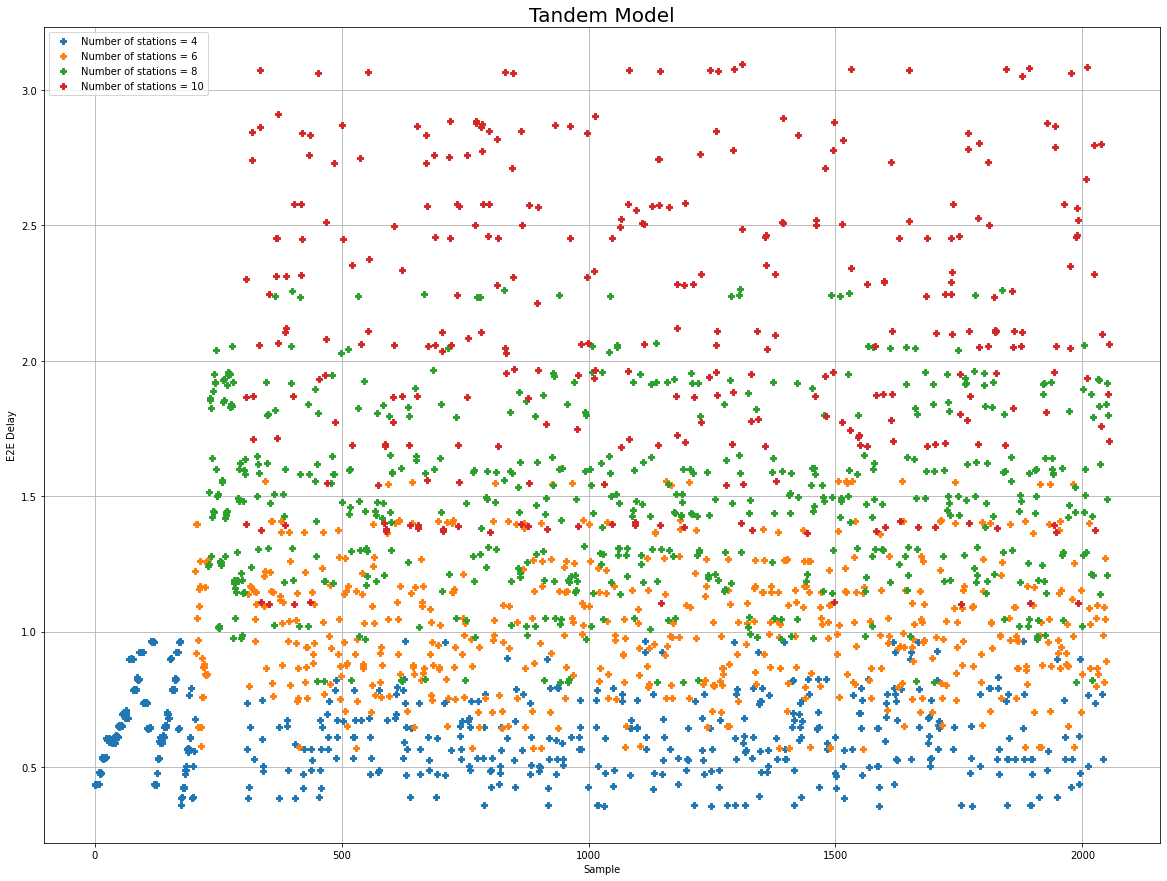

In [7]:
plt.figure(figsize=(20, 15))
plt.xlabel('Sample')
plt.ylabel('E2E Delay')
plt.title('Tandem Model', fontsize=20)

num_sta = train['num_stations'].unique()
k = 0
for i in num_sta:
    color = (0,.6,i) if k%2==0 else (i,0.2,i)
    plt.plot(train[(train['num_stations']==i)].loc[:,'e2e_delay'], marker='P',
            linestyle='', label= r'Number of stations = ' + str(i))
    k+=1
plt.legend()
plt.grid()

## Тестовая выборка

In [8]:
with open('../samples/test.json') as json_file:
    test = json.load(json_file)
test = pd.DataFrame.from_dict(test)
test

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay
0,-1,True,500000,UPLOAD,5,8,6,6,55,45,45,0.610650
1,-1,True,500000,UPLOAD,5,8,6,6,55,45,45,0.609057
2,-1,True,500000,UPLOAD,5,8,6,8,55,45,45,0.665402
3,-1,True,500000,UPLOAD,5,8,8,8,55,45,45,0.812524
4,-1,True,500000,UPLOAD,5,8,8,8,55,45,45,0.812761
...,...,...,...,...,...,...,...,...,...,...,...,...
186,-1,True,500000,UPLOAD,7,8,6,6,55,45,45,0.915217
187,-1,True,500000,UPLOAD,7,8,6,8,55,45,45,1.044579
188,-1,True,500000,UPLOAD,9,8,8,6,55,55,55,1.676341
189,-1,True,500000,UPLOAD,9,9,8,8,55,55,55,1.708432


In [9]:
x_test = test.iloc[:, 4:-1].values
y_test = test.iloc[:, -1].values

## МЕТРИКИ

In [10]:
def std(x: np.ndarray, y: np.ndarray)-> float:
    """
    Standard deviation between simulation model 
    values and our estimates
    """
    return math.sqrt(np.sum((x-y)**2) / (len(x) - 1))

In [11]:
def corr(x: np.ndarray, y: np.ndarray) -> float:
    r = np.corrcoef(x, y)
    return r[0,1]

In [59]:
tree = DecisionTreeRegressor(max_depth=15, splitter='best')
tree.fit(x_train, y_train);
tree_y = tree.predict(x_test)
dump(tree, 'tree_delays.joblib') 

['tree_delays.joblib']

In [54]:
tree_1 = load('tree_delays.joblib')

In [55]:
tree_y_1 = tree_1.predict(x_test)

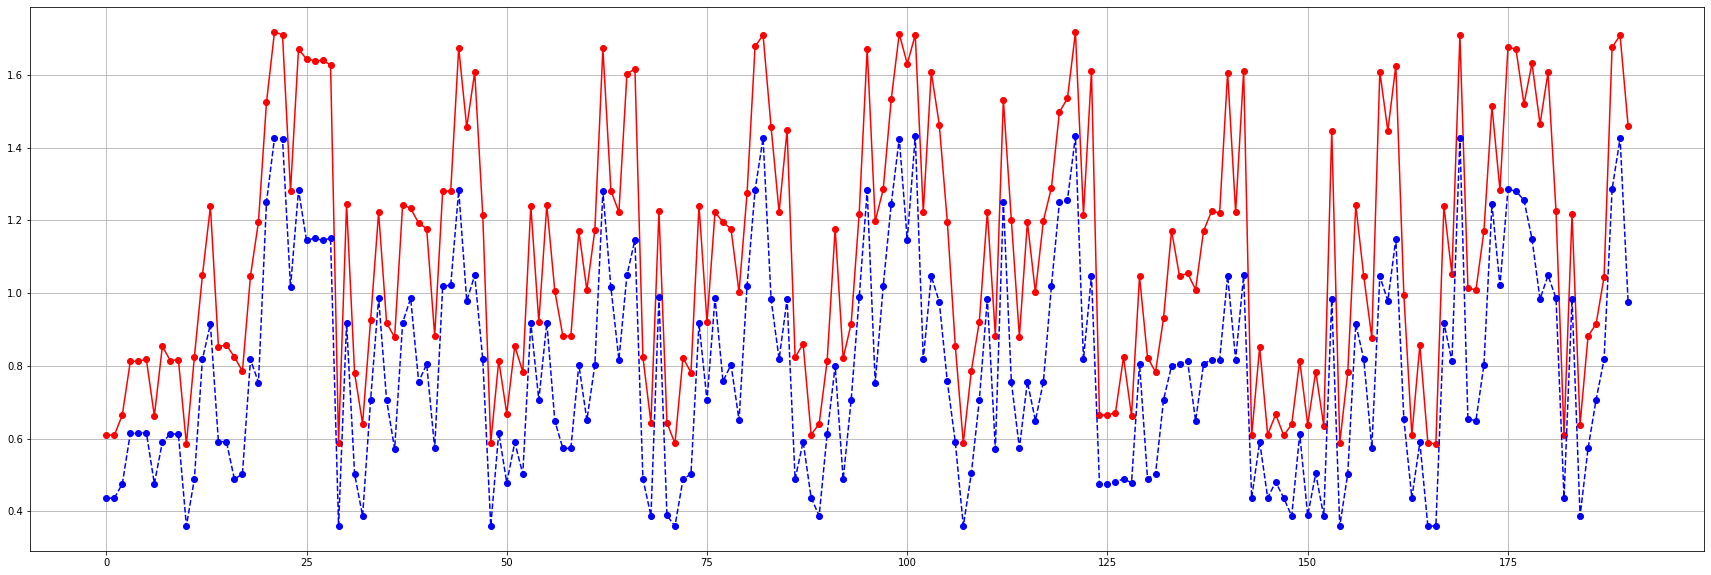

In [60]:
plt.figure(figsize=(30,10))
plt.plot(y_test, '-or')
plt.plot(tree_y, '--ob')
plt.grid()

In [14]:
corr(y_test, tree_y)

0.9665573755509681

In [15]:
std(y_test, tree_y)

0.3309379011656905

## ИСКУССТВЕННЫЕ НЕЙРОННЫЕ СЕТИ

In [16]:
def normalize(table, stat):
    """Prepare data for ANN"""
    return (table - stat.loc['mean',:].transpose())/ stat.loc['std',:].transpose()

In [17]:
train_normalize = normalize(train.iloc[:, 4:-1], train.iloc[:, 4:-1].describe())
train_normalize.to_numpy()

array([[-1.26367431, -0.97668236, -1.31671991, ..., -0.8952866 ,
        -1.22251365, -1.22251365],
       [-1.26367431, -0.97668236, -1.31671991, ..., -0.8952866 ,
         0.00178643,  0.00178643],
       [-1.26367431, -0.97668236, -1.31671991, ..., -0.8952866 ,
         0.00178643,  0.00178643],
       ...,
       [ 1.59768514,  1.02337634,  0.46725118, ..., -0.8952866 ,
         0.00178643,  0.00178643],
       [ 1.59768514,  1.02337634,  1.35923673, ..., -0.8952866 ,
         0.00178643,  0.00178643],
       [ 1.59768514, -0.97668236, -1.31671991, ...,  1.11641749,
        -1.22251365, -1.22251365]])

In [18]:
def build_model(size):
    model = keras.Sequential([
        # Input Layer
        layers.Dense(5, activation='sigmoid', use_bias=True, input_shape=[size]),
        # Hidden Layer
        layers.Dense(5, activation='sigmoid', use_bias=True),
        # Output layer
        layers.Dense(1)])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mse'])
    return model

In [19]:
model = build_model(len(train.iloc[:,4:-1].keys()))

In [20]:
%%time
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
EPOCHS = 1000
keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(train_normalize, y_train, epochs=EPOCHS, 
                    validation_split = 0.3, verbose=0, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)])

CPU times: user 23.1 s, sys: 1.99 s, total: 25.1 s
Wall time: 20.6 s


In [21]:
test_normalize = normalize(test.iloc[:,4:-1], train.iloc[:,4:-1].describe())
test_normalize.to_numpy()

array([[-0.78678107, -0.30999613, -0.87072714, ...,  0.11056545,
        -0.61036361, -0.61036361],
       [-0.78678107, -0.30999613, -0.87072714, ...,  0.11056545,
        -0.61036361, -0.61036361],
       [-0.78678107, -0.30999613, -0.87072714, ...,  0.11056545,
        -0.61036361, -0.61036361],
       ...,
       [ 1.1207919 , -0.30999613,  0.02125841, ...,  0.11056545,
         0.61393647,  0.61393647],
       [ 1.1207919 ,  0.35669011,  0.02125841, ...,  0.11056545,
         0.61393647,  0.61393647],
       [ 1.1207919 ,  0.35669011, -0.87072714, ...,  0.51290627,
        -0.61036361, -0.61036361]])

In [22]:
ann_y = model.predict(test_normalize).flatten()

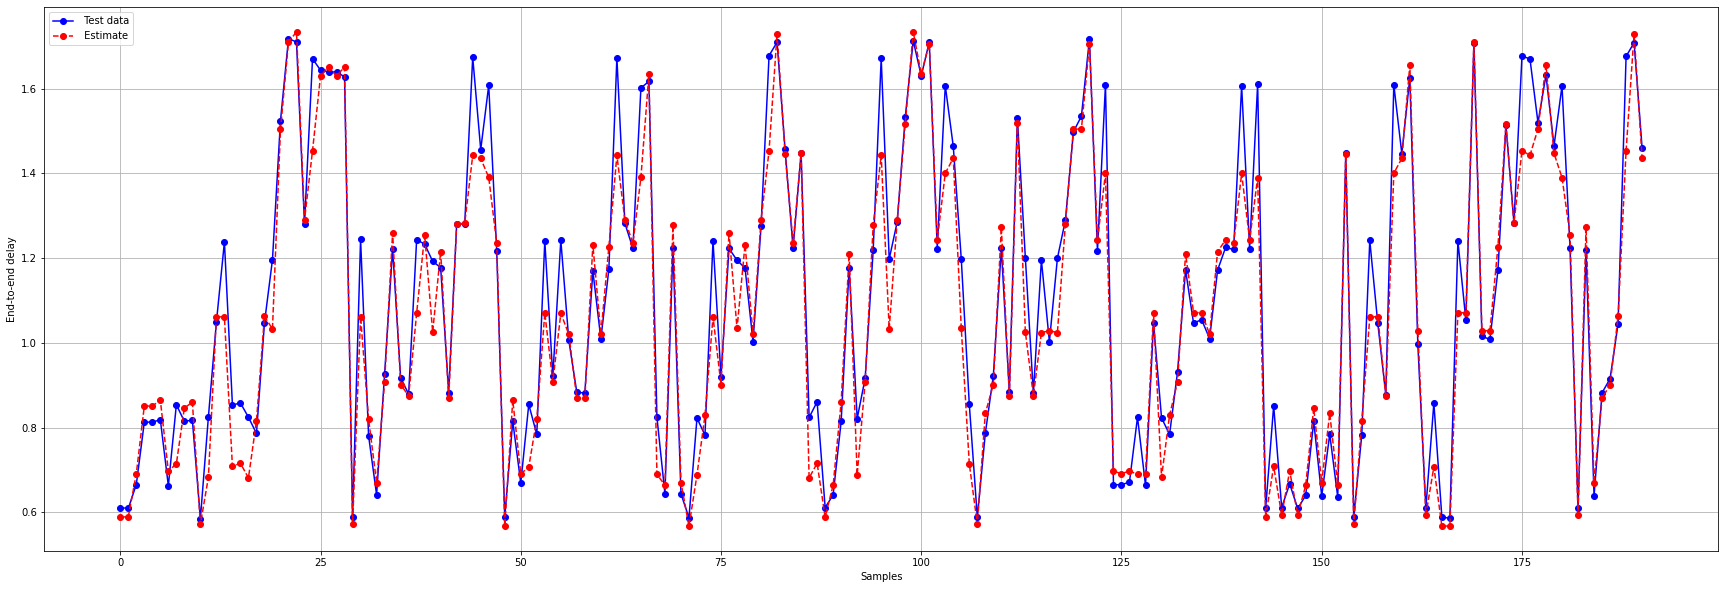

In [23]:
plt.figure(figsize=(30,10))
plt.plot(y_test, '-ob', label=' Test data')
plt.plot(ann_y, '--or', label=' Estimate')
plt.xlabel('Samples')
plt.ylabel('End-to-end delay')
plt.legend()
plt.grid()

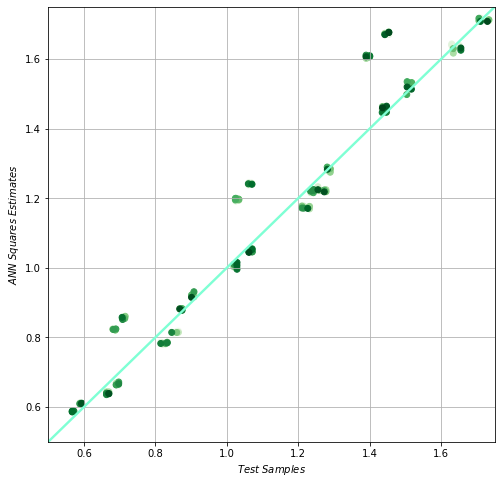

In [63]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid()
cm = plt.get_cmap('Greens')
col = [cm(float(i)/(len(y_test))) for i in range((len(y_test)))]
ax.scatter(ann_y, y_test, c=col)
x = np.linspace(0,2,100)
ax.plot(x, x, linestyle='-', linewidth=2.4, color='aquamarine')
# ax.set_title('Least Squares model \n SCATTER DIAGRAM \n  e2e delay estimate', fontweight='bold')

plt.xlim([0.5, 1.75])
plt.ylim([0.5, 1.75])

plt.xlabel(r'$Test \ Samples$');
plt.ylabel(r'$ANN \ Squares \ Estimates$');

In [24]:
corr(y_test, ann_y)

0.9693762946264676

In [34]:
std(y_test, ann_y)

0.09353336274935627

In [38]:
with open('../samples/results_5.json') as json_file:
    results_5 = json.load(json_file)
results_5 = pd.DataFrame.from_dict(results_5)
results_5 

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay
0,-1,True,500000,UPLOAD,5,8,6,6,55,45,45,0.610650
1,-1,True,500000,UPLOAD,5,8,6,6,55,45,45,0.609057
2,-1,True,500000,UPLOAD,5,8,6,8,55,45,45,0.665402
3,-1,True,500000,UPLOAD,5,8,8,8,55,45,45,0.812524
4,-1,True,500000,UPLOAD,5,8,8,8,55,45,45,0.812761
...,...,...,...,...,...,...,...,...,...,...,...,...
186,-1,True,500000,UPLOAD,7,8,6,6,55,45,45,0.915217
187,-1,True,500000,UPLOAD,7,8,6,8,55,45,45,1.044579
188,-1,True,500000,UPLOAD,9,8,8,6,55,55,55,1.676341
189,-1,True,500000,UPLOAD,9,9,8,8,55,55,55,1.708432


In [40]:
with open('../samples/results_4.json') as json_file:
    results_4 = json.load(json_file)
results_4 = pd.DataFrame.from_dict(results_4)
results_4 

,sta_where_packets_arrive,simulation_type,num_generated_packets,mode,num_stations,queue_capacity,mean_arrival_time,std_arrival_time,bitrate,mean_packet_size,std_mean_packet_size,e2e_delay
0,-1,True,500000,UPLOAD,4,7,5,5,50,40,40,0.435725
1,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437986
2,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437255
3,-1,True,500000,UPLOAD,4,7,5,5,50,50,50,0.437979
4,-1,True,500000,UPLOAD,4,7,5,5,50,60,60,0.438589
...,...,...,...,...,...,...,...,...,...,...,...,...
2051,-1,True,500000,UPLOAD,8,7,11,9,60,60,60,1.208271
2052,-1,True,500000,UPLOAD,8,10,11,11,60,50,50,1.801500
2053,-1,True,500000,UPLOAD,10,10,9,5,50,50,50,1.876791
2054,-1,True,500000,UPLOAD,10,10,11,9,50,50,50,2.061192
